# DATA620: Project 1

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

### Data

For this project, we will be working with a high school contact and friendship network dataset obtained from a previously completed research project on comparison between data collected using wearable sensors, contact diaries, and friendship surveys. We obtained the data from http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/. The dataset contains information from 327 individuals who took part in the study and includes five datasets broken into the following:

* Dynamical contact list
* Directed, weighted contact network from contact diaries
* List of pairs of students for which the existence of Facebook link is known
* Metadata contains a tab-separated list in which each line consists of studentId, class and gender

Our three primary data sources are the 'Dynamical contact list', 'Directed, weighted contact network' and the 'Metadata' datasets. We are provided with nodes of students who were given an anonymous ID (329 nodes) for privacy, the classes where each student socialized, the time of each student interaction, and the gender of the student. The edges in the graph represent social contact between students with the weighted distance reflecting social proximity (5,818 directed edges).

### Hypothetical Outcome

We would like discover if one gender is, substantially, making more interpersonal connections than another. Theoretically, we should see that males and females are as equally as likely to connect to another individual. We may find that this in that the case in our dataset.

* H0 - The average Eigenvector Centrality measures for male students is equal to the average Eigenvector Centrality measures for  female students.
* H1 - The average Eigenvector Centrality measures for male students is different from the average Eigenvector Centrality measures for female students.

### Loading the data

In [44]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
import plotly.express as px
plt.rcParams.update({'axes.facecolor':'orange'})

In [45]:
# Import Dynamical contact list
school_data = pd.read_csv('https://raw.githubusercontent.com/SaneSky109/DATA620/main/Data/High-School_data_2013.csv',
                          sep = ' ',
                         header = None,
                         names = ["Time_sec", "StudentID1", "StudentID2", "Class1", "Class2"])
school_data.head(5)

,Time_sec,StudentID1,StudentID2,Class1,Class2
0,1385982020,454,640,MP,MP
1,1385982020,1,939,2BIO3,2BIO3
2,1385982020,185,258,PC*,PC*
3,1385982020,55,170,2BIO3,2BIO3
4,1385982020,9,453,PC,PC


In [46]:
school_data.shape

(188508, 5)

In [47]:
# Import Metadata
attribute_data = pd.read_csv('http://www.sociopatterns.org/wp-content/uploads/2015/09/metadata_2013.txt',
                   sep = '\t',
                   header = None,
                   names = ["studentID", "Class", "Gender"])
attribute_data.head(5)

,studentID,Class,Gender
0,650,2BIO1,F
1,498,2BIO1,F
2,627,2BIO1,F
3,857,2BIO1,F
4,487,2BIO1,F


In [48]:
attribute_data.shape

(329, 3)

### Transforming the Data

In [49]:
# Create Weights. Students can contact eachother multiple times in a class. Weights can capture how often the students communicate.
weighted_data = school_data.groupby(['StudentID1', 'StudentID2']).size().reset_index(name="Contacts")

# Create weights using 1/contacts to have people who are more social with eachother closer than people who hardly socialize with eachother
weighted_data["weight"] = 1 / weighted_data["Contacts"]

weighted_data.head(5)

,StudentID1,StudentID2,Contacts,weight
0,1,55,8,0.125000
1,1,63,2,0.500000
2,1,101,1,1.000000
3,1,106,4,0.250000
4,1,117,18,0.055556


In [50]:
weighted_data.shape

(5818, 4)

### NetworkX Graph Object

In [51]:
# create a directed graph using the weighted edges
g = nx.from_pandas_edgelist(weighted_data, 
                            source='StudentID1', 
                            target='StudentID2', 
                            create_using = nx.DiGraph(),
                            edge_attr = ["Contacts", "weight"]
                           ) 

In [52]:
# transform the meta data into a dictionary
zip_iter = zip(attribute_data['studentID'].tolist(), attribute_data['Gender'].tolist())
a_dict = dict(zip_iter)

In [53]:
# add attributes to each node in the graph
for key,n in g.nodes.items():
    n["Gender"]=a_dict[key]

### Graph
The resulting graph depicts a dense cluster of nodes and edges. It should be noted that there are 8 small clusters of nodes that have a higher weighted distantance from main cluster.

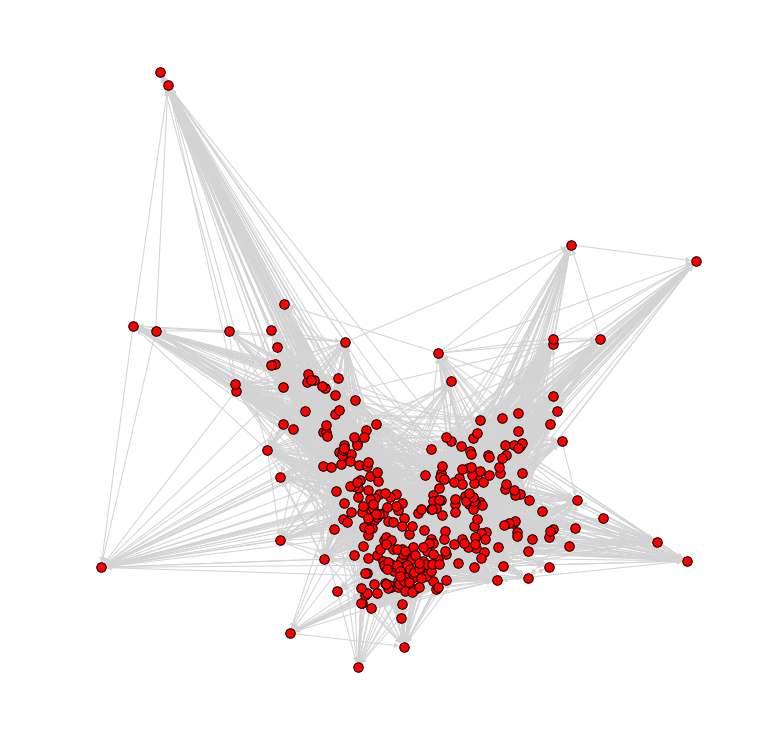

In [54]:
plt.figure(figsize = (10,10))
nx.draw(g, with_labels = False, node_size = 90, font_color = 'black', edgecolors='black',
         font_weight = 'bold', node_color='red', edge_color='lightgray', arrowsbool=True )

### Sub Graph
Filtering the student graph by all edges with a weight that is less than 0.005 generates a sub graph that is provides a little more clarity on the overall structure.

In [55]:
w = 0.005
sub_g = nx.subgraph(g,
                    ((source) for source, target, attr in g.edges(data=True) 
                    if attr['weight'] < w))

In [56]:
print('Filtering the student graph by all edges with a weight that is less than ' 
      + str(w) + ' generates as sub graph with ' + str(len(sub_g)) + ' nodes')

Filtering the student graph by all edges with a weight that is less than 0.005 generates as sub graph with 137 nodes


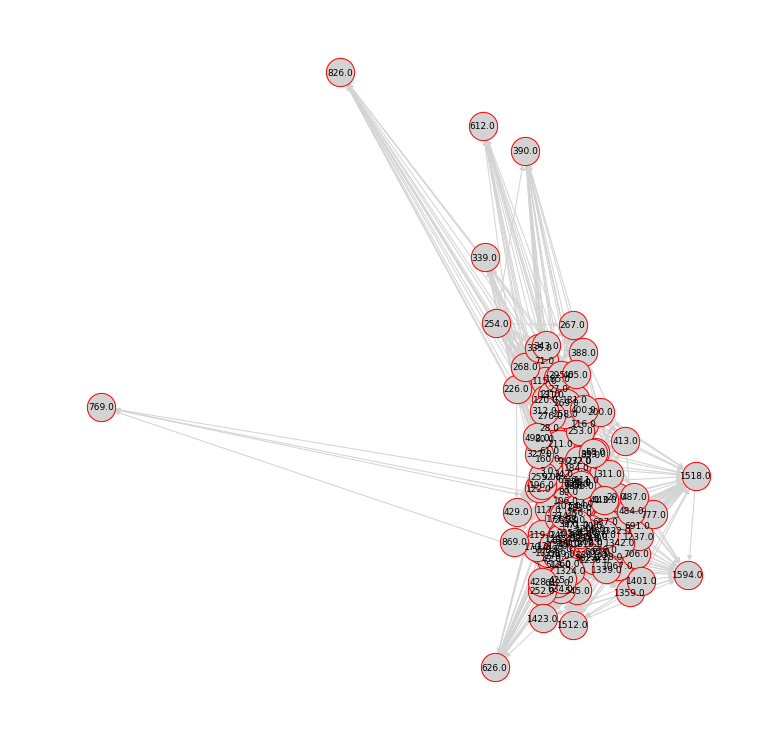

In [57]:
plt.figure(figsize = (10,10))
nx.draw(sub_g, with_labels = True, node_size = 800, font_color = 'black', font_size=9,
        edge_color='lightgray', edgecolors='red', node_color='lightgray', arrowsbool=True)

### Degree Centrality

In [58]:
deg=nx.degree(g)
deg_s = dict(sorted(dict(deg).items(), key=lambda item: item[1],reverse=True)[:10])
deg_s

{106.0: 87,
 1518.0: 84,
 1332.0: 77,
 272.0: 76,
 605.0: 72,
 1359.0: 69,
 9.0: 69,
 232.0: 68,
 376.0: 67,
 275.0: 67}

Degree centrality measures the number of connections an individual node has. The first line in the output above shows us a student with the highest number of contacts. This is the top user in the dataset. 

### Closeness Centrality 

In [59]:
c=nx.closeness_centrality(g)
cs = dict(sorted(c.items(), key=lambda item: item[1],reverse=True)[:10])
cs

{1518.0: 0.49436659873499256,
 1423.0: 0.46783757720007385,
 1512.0: 0.454302343872896,
 1894.0: 0.4542853218569728,
 1359.0: 0.44787348698391644,
 1594.0: 0.4468429087529987,
 1805.0: 0.44647332784677535,
 1332.0: 0.4384028361284084,
 1819.0: 0.4316036252908047,
 1828.0: 0.4271834434819243}

Students with high closeness centrality have a high ability to move information from one side of the network to another. The top ten list indicates nodes that are more central. These students are closer to most of the other student nodes in the graph.

### Boundary Spanners

In [60]:
b=nx.betweenness_centrality(g)
bs = dict(sorted(b.items(), key=lambda item: item[1],reverse=True)[:10])
bs

{605.0: 0.014865800569258862,
 674.0: 0.014845753896991328,
 272.0: 0.011763082788901497,
 245.0: 0.010455203874467361,
 376.0: 0.00907112727440966,
 372.0: 0.00871512803596813,
 424.0: 0.007556434230106044,
 275.0: 0.007419530814581692,
 1332.0: 0.007137200130949082,
 407.0: 0.006962806277102555}

Betweenness centrality shows us students that act as bridges between communities that otherwise would not be able to communicate with each other. 

### Eigenvector Centrality

In [61]:
e = nx.eigenvector_centrality(g, max_iter=1000) 
es = dict(sorted(e.items(), key=lambda item: item[1],reverse=True)[:10])
es

{1894.0: 0.995934181862536,
 1828.0: 0.07326103247116662,
 1819.0: 0.03799368416357973,
 1870.0: 0.03531691982142628,
 1784.0: 0.005347315286971633,
 1805.0: 0.005304012227396992,
 1594.0: 0.00039260541323285557,
 1543.0: 0.00034853951983630007,
 1519.0: 0.0003422296364468425,
 1518.0: 5.0485733719803415e-05}

Degree centrality awards one centrality point for every link a node receives. Not all student connections are equivalent: some are more important than others, and, reasonably, connections with "popular" students count more. It looks like a student with ID # 1894 is extremely influential but does not necessarily have a lot of connections. 

### page rank centrality

In [62]:
pr=nx.pagerank(g) 
prs = dict(sorted(pr.items(), key=lambda item: item[1],reverse=True)[:10])
prs

{1894.0: 0.093215000104072687,
 1828.0: 0.037971295334678579,
 1784.0: 0.021680839767477134,
 1819.0: 0.019965346849316612,
 991.0: 0.017845819785267301,
 1518.0: 0.017475816125924009,
 1805.0: 0.016464633081219201,
 1332.0: 0.016027894185480233,
 1870.0: 0.01468995647286038,
 1423.0: 0.013718543012471092}

We can see a lot of familiar student IDs in all the top ten lists. Every network has a group of popular users that will be more noticeable than others across all centrality metrics.  

### Centrality Measures Summary Table

In [63]:
df = attribute_data.copy()
df.head()

,studentID,Class,Gender
0,650,2BIO1,F
1,498,2BIO1,F
2,627,2BIO1,F
3,857,2BIO1,F
4,487,2BIO1,F


In [64]:
df['Degree'] = df['studentID'].map(dict(deg))
df['Closeness'] = df['studentID'].map(dict(c))
df['Betweenness'] = df['studentID'].map(dict(b))
df['Eigenvector'] = df['studentID'].map(dict(e))
df['PageRank'] = df['studentID'].map(dict(pr))
df.head().round(decimals=4)

,studentID,Class,Gender,Degree,Closeness,Betweenness,Eigenvector,PageRank
0,650,2BIO1,F,39.0,0.2048,0.0013,0.0,0.0026
1,498,2BIO1,F,44.0,0.2035,0.0029,0.0,0.0029
2,627,2BIO1,F,22.0,0.1862,0.0005,0.0,0.0018
3,857,2BIO1,F,24.0,0.2412,0.0015,0.0,0.0028
4,487,2BIO1,F,40.0,0.1656,0.0014,0.0,0.0013


### Centrality measures comparison 

#### Degree

In [65]:
df.groupby("Gender")["Degree"].describe().round(decimals=4)

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,36.4828,14.1545,2.0,29.0,36.0,43.0,87.0
M,175.0,34.8857,13.0441,8.0,25.5,35.0,42.0,84.0
Unknown,7.0,34.4286,12.2863,18.0,27.0,35.0,41.0,52.0


The degree centrality on average was higher for Female students. This means that female students have a higher number of connections compared to male students. 

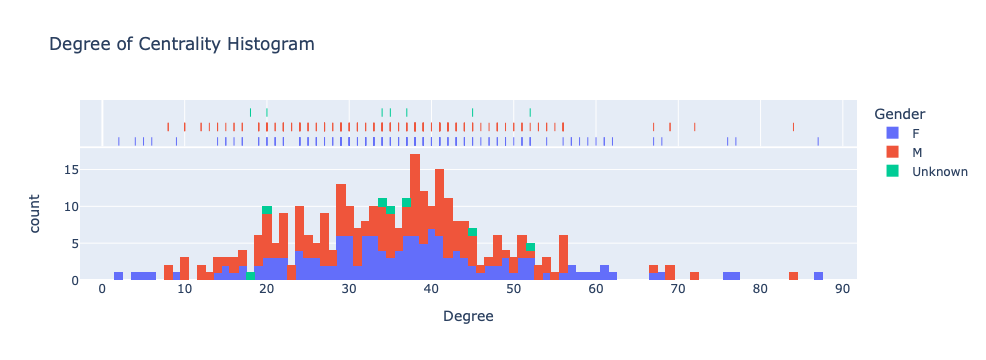

In [66]:
fig = px.histogram(df, x="Degree", color="Gender", marginal="rug",nbins=100, hover_data=df.columns,
                  title="Degree of Centrality Histogram")
fig.show()

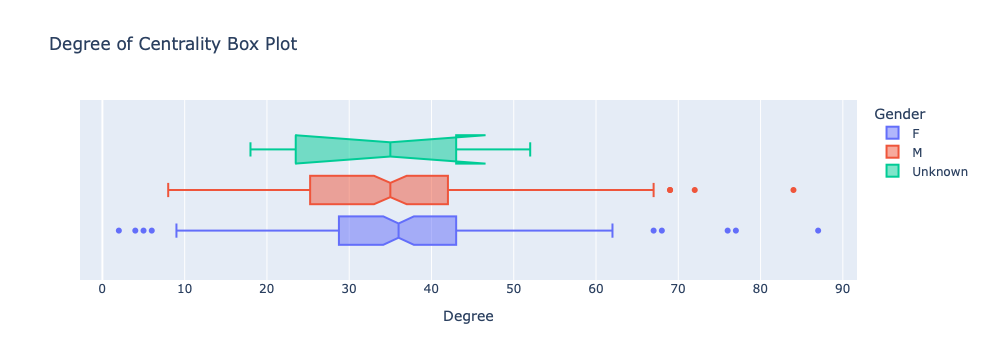

In [67]:
fig = px.box(df, x="Degree", color="Gender", notched=True, title="Degree of Centrality Box Plot")
fig.show()

#### Closeness

In [68]:
df.groupby("Gender")["Closeness"].describe().round(decimals=4)

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,0.1574,0.1074,0.0,0.0652,0.1453,0.2412,0.4543
M,175.0,0.1824,0.1226,0.0,0.0899,0.1776,0.2676,0.4944
Unknown,7.0,0.0769,0.0900,0.0,0.0123,0.0595,0.1009,0.2525


Interestingly the highest closeness centrality was for male students, meaning that they have a higher ability to move information from one side of the network to another. 

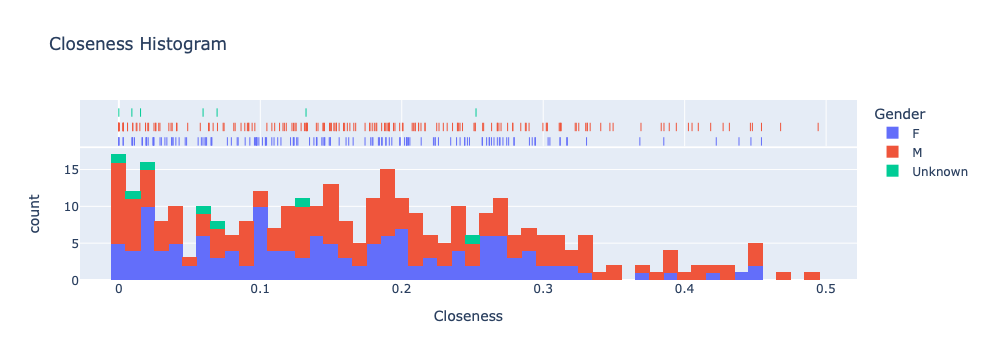

In [69]:
fig = px.histogram(df, x="Closeness", color="Gender", marginal="rug",nbins=80, hover_data=df.columns,
                  title="Closeness Histogram")
fig.show()

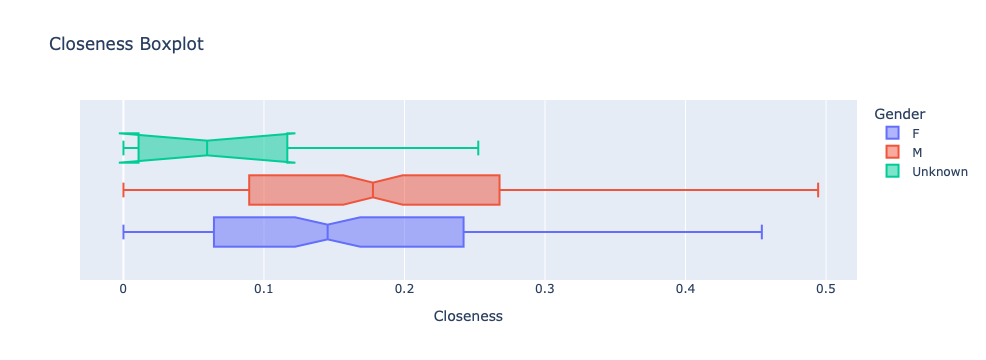

In [70]:
fig = px.box(df, x="Closeness", color="Gender", notched=True, title="Closeness Boxplot")
fig.show()

#### Betweenness

In [71]:
df.groupby("Gender")["Betweenness"].describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,0.001934,0.002294,0.0,0.000410,0.001133,0.002688,0.014846
M,175.0,0.001529,0.002007,0.0,0.000177,0.000808,0.002018,0.014866
Unknown,7.0,0.000903,0.000838,0.0,0.000339,0.000634,0.001456,0.002096


Female students tend to act as communication bridges across communities that otherwise would not be able to communicate with each other.

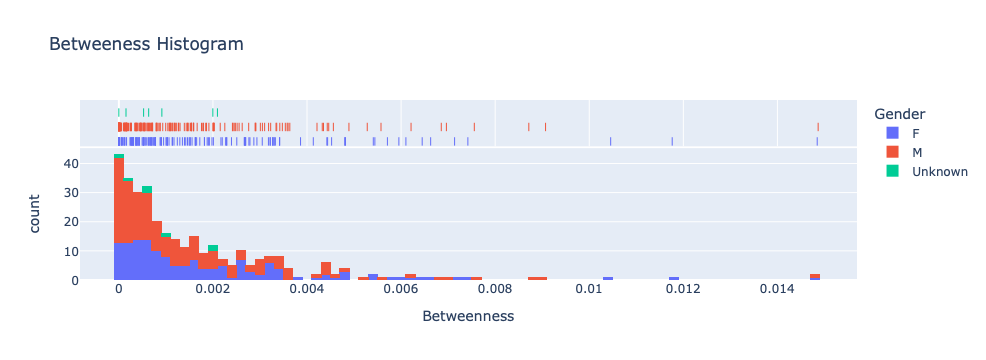

In [72]:
fig = px.histogram(df, x="Betweenness", color="Gender", marginal="rug",nbins=80, hover_data=df.columns,
                  title="Betweeness Histogram")
fig.show()

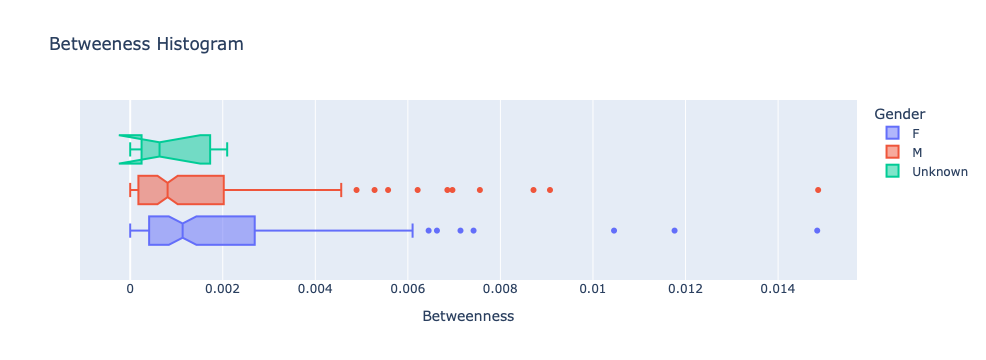

In [73]:
fig = px.box(df, x="Betweenness", color="Gender", notched=True, title="Betweeness Histogram")
fig.show()

#### Eigenvector

In [74]:
df.groupby("Gender")["Eigenvector"].describe().round(decimals=4)

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,0.0069,0.0827,0.0,0.0,0.0,0.0,0.9959
M,175.0,0.0009,0.0068,0.0,0.0,0.0,0.0,0.0733
Unknown,7.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000


Female students have higher eigenvector centrality. They can be largely invisible in the network and have a lower number of connections but still have more communication power by knowing well-connected students.

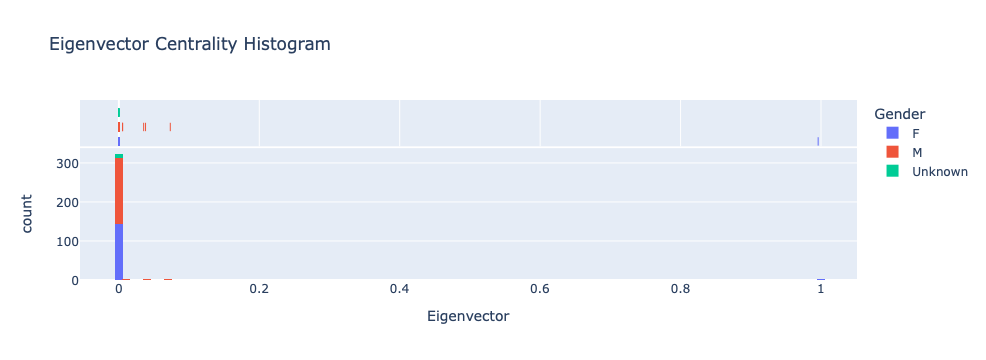

In [75]:
fig = px.histogram(df, x="Eigenvector", color="Gender", marginal="rug",nbins=100, hover_data=df.columns,
                  title="Eigenvector Centrality Histogram")
fig.show()

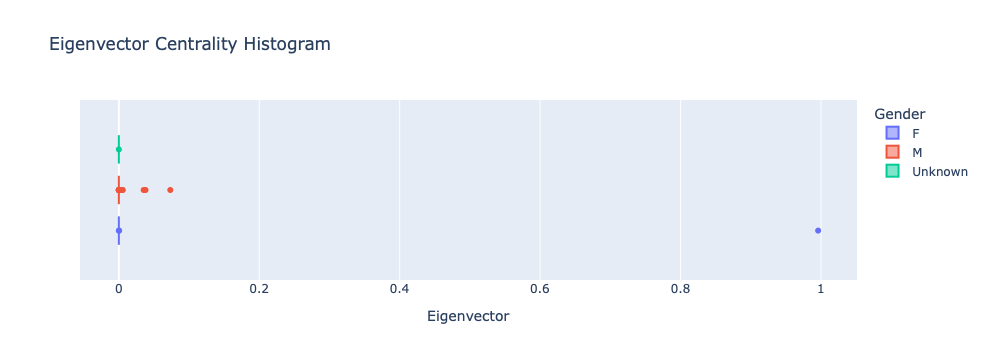

In [76]:
fig = px.box(df, x="Eigenvector", color="Gender", notched=True, title="Eigenvector Centrality Histogram")
fig.show()

#### PageRank

In [77]:
df.groupby("Gender")["PageRank"].describe().round(decimals=4)

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,145.0,0.0030,0.0079,0.0009,0.0011,0.0015,0.0028,0.0932
M,175.0,0.0032,0.0046,0.0009,0.0011,0.0016,0.0027,0.0380
Unknown,7.0,0.0013,0.0009,0.0009,0.0009,0.0010,0.0011,0.0032


PageRank measures the importance of each node within the group, based on the number incoming relationships and the importance of the corresponding source nodes. Only immediate neighbors are taken into consideration. This measure looks similar for both genders.

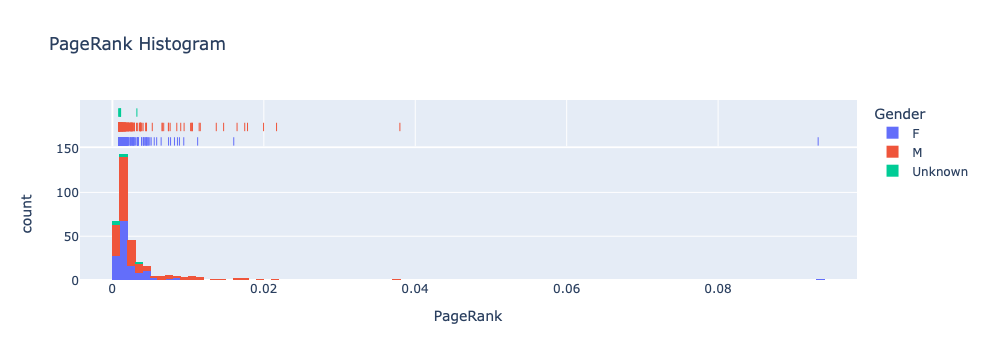

In [78]:
fig = px.histogram(df, x="PageRank", color="Gender", marginal="rug",nbins=100, hover_data=df.columns,
                  title="PageRank Histogram")
fig.show()

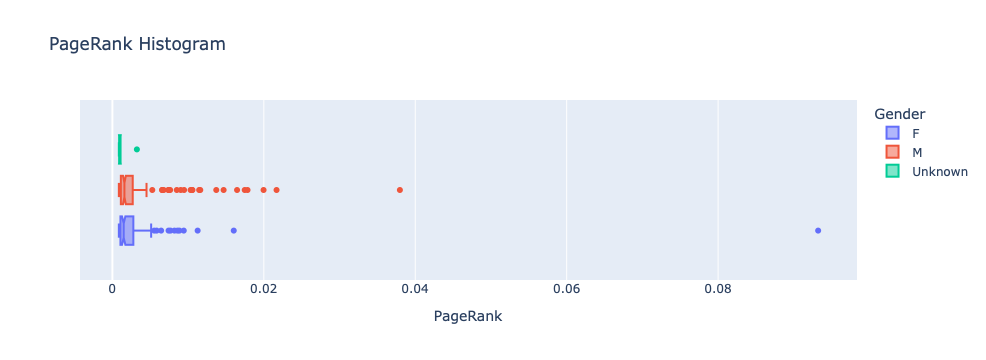

In [79]:
fig = px.box(df, x="PageRank", color="Gender", notched=True, title="PageRank Histogram")
fig.show()

### 3D Exploration

In [80]:
fig = px.scatter_3d(df, x="Degree", y="Betweenness", z="PageRank", color="Gender", 
                    hover_name="studentID", width=1100, height=800, title="Student Node Attribute Comparison Plot")
fig.show()

### T-Test

We would like to test to see if there is a significant difference between male and female students across several centrality measures.

* H0 - The average Eigenvector Centrality measures for male students is equal to the average Eigenvector Centrality measures for  female students.
* H1 - The average Eigenvector Centrality measures for male students is different from the average Eigenvector Centrality measures for female students.

T-Test Assumptions:
* The first assumption made regarding t-tests concerns the scale of measurement. The assumption for a t-test is that the scale of measurement applied to the data collected follows a continuous or ordinal scale, such as the scores for an IQ test.
* The second assumption made is that of a simple random sample, that the data is collected from a representative, randomly selected portion of the total population.
* The third assumption is the data, when plotted, results in a normal distribution, bell-shaped distribution curve. When a normal distribution is assumed, one can specify a level of probability (alpha level, level of significance, p) as a criterion for acceptance. In most cases, a 5% value can be assumed.
* The fourth assumption is a reasonably large sample size is used. A larger sample size means the distribution of results should approach a normal bell-shaped curve.
* The final assumption is homogeneity of variance. Homogeneous, or equal, variance exists when the standard deviations of samples are approximately equal.

In [81]:
# T-Test is for 2 group comparison. Unknown gender will be dropped leaving only M and F.

df_t_test = df.copy()

df_t_test = df_t_test.drop(df_t_test[df_t_test.Gender == "Unknown"].index)

# Create 2 dataframes: male and female

male = df_t_test[df_t_test['Gender'] == "M"]
female = df_t_test[df_t_test['Gender'] == "F"]

male_t_test = male[["Degree", "Closeness", "Betweenness", "Eigenvector", "PageRank"]]
female_t_test = female[["Degree", "Closeness", "Betweenness", "Eigenvector", "PageRank"]]

#### Degree 

In [82]:
t_value, p_value = ttest_ind(male_t_test.dropna()['Degree'], female_t_test.dropna()['Degree'])

print("T-Value: ", t_value)
print("P-Value: ", p_value)

T-Value:  -1.04892470542
P-Value:  0.295009300204


We failed to reject the null hypothesis for the degree centrality measure. This indicates that, given a 95% confidence level, there is no significant difference in degree centrality between male and female students.

#### Closeness

In [83]:
t_value, p_value = ttest_ind(male_t_test.dropna()['Closeness'], female_t_test.dropna()['Closeness'])

print("T-Value: ", t_value)
print("P-Value: ", p_value)

T-Value:  1.92063770268
P-Value:  0.0556714174271


We failed to reject the null hypothesis for the closeness centrality measure, though it is extremely close to meeting the 95% confidence level requirement. At the 10% confidence level, there is a statistically significant difference between male and female closeness measures.

#### Betweenness

In [84]:
t_value, p_value = ttest_ind(male_t_test.dropna()['Betweenness'], female_t_test.dropna()['Betweenness'])

print("T-Value: ", t_value)
print("P-Value: ", p_value)

T-Value:  -1.68355933656
P-Value:  0.0932482080846


We failed reject the null hypothesis for the betweenness centrality measure.  This proves that, given a 95% confidence level, there is not a significant difference in betweenness across male and female students.

#### Eigenvector

In [85]:
t_value, p_value = ttest_ind(male_t_test.dropna()['Eigenvector'], female_t_test.dropna()['Eigenvector'])

print("T-Value: ", t_value)
print("P-Value: ", p_value)

T-Value:  -0.951111594068
P-Value:  0.342270045476


We failed reject the null hypothesis for the eigevector centrality measure. The t-test strongly suggests that there is no significant evidence proving that there is a difference between male and female students' eigenvector measures.

#### Page Rank

In [86]:
t_value, p_value = ttest_ind(male_t_test.dropna()['PageRank'], female_t_test.dropna()['PageRank'])

print("T-Value: ", t_value)
print("P-Value: ", p_value)

T-Value:  0.300454871454
P-Value:  0.764026542014


We failed to reject the null hypothesis for the page rank measure. The t-test result signifies that there is no difference between the male students and female students, in terms of page rank. 

### Conclusion

The analysis has shown that there is not enough sufficient evidence in the data sources to prove a relationship between a high school student's gender and its degree, centrality, closeness, eigenvector centrality, and page rank. Though each centrality measure favored a gender group, the statistical tests proved that the measures did not significantly differ between groups. This result matches our original assumption, indicating that males and females are equally as likely to connect to another individual.